In [1]:
import os
from os import path
from argparse import ArgumentParser

import numpy as np
import torch
import torchvision.transforms.functional as TF
import cv2

from model.network import deeplabv3plus_resnet50 as S2M
from model.aggregate import aggregate_wbg_channel as aggregate
from dataset.range_transform import im_normalization
from util.tensor_util import pad_divide_by
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from torchsummary import summary
from torch import nn
from torch.nn import functional as F
import math
from model_base import Base
from typing import List
import cv2
torch.backends.cudnn.benchmark = True

In [2]:
net = Base("resnet50", 7, 1)
net.load_state_dict(torch.load('./saves/0.009609096754474689')['model_state_dict'])
net = net.cuda().eval()
torch.set_grad_enabled(False)

In [3]:
def limit_longest_size(image, max_side_size):
    if image.shape[0] > image.shape[1]:
        target_h = min(image.shape[0], max_side_size)
        target_w = int(image.shape[1] / image.shape[0] * target_h + 0.5)
    else:
        target_w = min(image.shape[1], max_side_size)
        target_h = int(image.shape[0] / image.shape[1] * target_w + 0.5)
    image = cv2.resize(image, (target_w, target_h), interpolation=cv2.INTER_LINEAR)
    return image

In [5]:
from clicker import Clicker
import tqdm

In [6]:
alpha_copy = r'C:\Users\andry\Desktop\Combined_Dataset\Test_set\Composition-1k-testset\alpha_copy'
merged = r'C:\Users\andry\Desktop\Combined_Dataset\Test_set\Composition-1k-testset\merged'
#trimaps = r'C:\Users\andry\Desktop\Combined_Dataset\Test_set\Composition-1k-testset\trimaps'

In [8]:
class InteractiveManager:
    def __init__(self, model, image, mask):
        self.model = model

        self.image = im_normalization(TF.to_tensor(image)).unsqueeze(0).cuda()
        self.mask = TF.to_tensor(mask).unsqueeze(0).cuda()

        h, w = self.image.shape[-2:]
        self.max_size = max(h,w)
        self.image, self.pad = pad_divide_by(self.image, 16)
        self.mask, _ = pad_divide_by(self.mask, 16)
        self.last_mask = None

        # Positive and negative scribbles
        self.p_srb = np.zeros((h, w), dtype=np.uint8)
        self.n_srb = np.zeros((h, w), dtype=np.uint8)
        self.s_srb = np.zeros((h, w), dtype=np.uint8)

        # Used for drawing
        self.pressed = False
        self.last_ex = self.last_ey = None
        self.mode = 0
        self.need_update = True

    def mouse_down(self, ex, ey):
        self.last_ex = ex
        self.last_ey = ey
        self.pressed = True
        if self.mode == 0:
            cv2.circle(self.p_srb, (ex, ey), radius=int(self.max_size * (5/512)), color=(1), thickness=-1)
        elif self.mode == 1:
            cv2.circle(self.n_srb, (ex, ey), radius=int(self.max_size * (5/512)), color=(1), thickness=-1)
        elif self.mode == 2:
            cv2.circle(self.s_srb, (ex, ey), radius=int(self.max_size * (5/512)), color=(1), thickness=-1)
        self.need_update = True

    def mouse_up(self):
        self.pressed = False

    first = True

    def run_s2m(self):
        # Convert scribbles to tensors
        Rsp = torch.from_numpy(self.p_srb).unsqueeze(0).unsqueeze(0).float().cuda()
        Rsn = torch.from_numpy(self.n_srb).unsqueeze(0).unsqueeze(0).float().cuda()
        Rss = torch.from_numpy(self.s_srb).unsqueeze(0).unsqueeze(0).float().cuda()
        Rs = torch.cat([Rsn, Rsp, Rss], 1)
        Rs, _ = pad_divide_by(Rs, 16)

        # Use the network to do stuff
        inputs = torch.cat([self.image, self.mask, Rs], 1)
        mask = net(inputs)
        #inputs = torch.cat([self.image, mask, Rs], 1)
        #mask = net(inputs)
        #print(mask)
        # We don't overwrite current mask until commit            
        self.last_mask = mask
        np_mask = (mask.detach().cpu().numpy()[0,0] * 255).astype(np.uint8)

        if self.pad[2]+self.pad[3] > 0:
            np_mask = np_mask[self.pad[2]:-self.pad[3],:]
        if self.pad[0]+self.pad[1] > 0:
            np_mask = np_mask[:,self.pad[0]:-self.pad[1]]

        return np_mask

    def commit(self):
        self.p_srb.fill(0)
        self.n_srb.fill(0)
        self.s_srb.fill(0)
        if self.last_mask is not None:
            self.mask = self.last_mask

    def clean_up(self):
        self.p_srb.fill(0)
        self.n_srb.fill(0)
        self.s_srb.fill(0)
        self.mask.zero_()
        self.last_mask = None

In [9]:
def comp_image(image, mask, p_srb, n_srb, s_srb):
    color_mask = np.zeros_like(image, dtype=np.uint8)
    color_mask[:,:,2] = 1
    if len(mask.shape) == 2:
        mask = mask[:,:,None]
    comp = (image*0.5 + color_mask*mask*0.5).astype(np.uint8)
    comp[p_srb>0.5, :] = np.array([0, 255, 0], dtype=np.uint8)
    comp[s_srb>0.5, :] = np.array([255, 0, 0], dtype=np.uint8)
    comp[n_srb>0.5, :] = np.array([0, 0, 255], dtype=np.uint8)
    return comp

In [10]:
for name in tqdm.tqdm(os.listdir(merged)):
    gt_alpha = cv2.imread(os.path.join(alpha_copy, name), cv2.IMREAD_GRAYSCALE)
    gt_size = gt_alpha.shape
    gt_alpha = limit_longest_size(gt_alpha, 1024)
    
    image = cv2.imread(os.path.join(merged, name), cv2.IMREAD_COLOR)
    image = limit_longest_size(image, 1024)
    prev_mask = np.zeros_like(gt_alpha)
    
    clicker_pos = Clicker(gt_alpha > 200)
    clicker_neg = Clicker(gt_alpha == 0)
    clicker_trans = Clicker((gt_alpha > 0) & (gt_alpha <= 200))
    
    interactive_manager = InteractiveManager(net, image, prev_mask)
    total_clicks = 0
    for click_indx in range(0, 25):
        
        prev_mask_pos = prev_mask > 128
        prev_mask_neg = prev_mask == 0
        prev_mask_trans = (prev_mask > 0) & (prev_mask <= 128)
        
        clicker_pos.make_next_click(prev_mask_pos)
        clicker_neg.make_next_click(prev_mask_neg)
        clicker_trans.make_next_click(prev_mask_trans)
        
        clicks_pos = clicker_pos.get_clicks()
        last_click_pos = clicks_pos[-1]
        if last_click_pos.is_positive:
            interactive_manager.mode = 0
            interactive_manager.mouse_down(last_click_pos.coords[1], last_click_pos.coords[0])
#         else:
#             interactive_manager.mode = 1
#             interactive_manager.mouse_down(last_click_pos.coords[1], last_click_pos.coords[0])
            total_clicks += 1
    
        clicks_neg = clicker_neg.get_clicks()
        last_click_neg = clicks_neg[-1]
        if last_click_neg.is_positive:
            interactive_manager.mode = 1
            interactive_manager.mouse_down(last_click_neg.coords[1], last_click_neg.coords[0])
            total_clicks += 1
#         else:
#             interactive_manager.mode = 0
#             interactive_manager.mouse_down(last_click_neg.coords[1], last_click_neg.coords[0])
        
        clicks_trans = clicker_trans.get_clicks()
        last_click_trans = clicks_trans[-1]
        if last_click_trans.is_positive:
            interactive_manager.mode = 2
            interactive_manager.mouse_down(last_click_trans.coords[1], last_click_trans.coords[0])
            total_clicks += 1
#         else:
#             interactive_manager.mode = 1
#             interactive_manager.mouse_down(last_click_trans.coords[1], last_click_trans.coords[0])
            
        prev_mask = interactive_manager.run_s2m()
        
        display = comp_image(image, prev_mask, interactive_manager.p_srb, interactive_manager.n_srb, interactive_manager.s_srb)
        
        os.makedirs(os.path.join('./compositions_vis', name), exist_ok=True)
        cv2.imwrite(os.path.join('./compositions_vis', name, str(click_indx).zfill(3) + '_' + str(total_clicks) + '.jpg'), display) 
        
        outs = cv2.resize(prev_mask, (gt_size[1], gt_size[0]), interpolation=cv2.INTER_LINEAR)
        os.makedirs(os.path.join('./compositions_outputs', name), exist_ok=True)
        #cv2.imwrite(os.path.join('./compositions_outputs', name, str(click_indx).zfill(3) + '_' + str(total_clicks) + '.png'), outs)
        cv2.imwrite(os.path.join('./compositions_outputs', name, str(click_indx).zfill(3) + '.png'), outs) 

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:14:15<00:00,  4.46s/it]


In [ ]:
!python evaluation.py

In [12]:
mse = np.load('./mse.npy', allow_pickle=True)
sad = np.load('./sad.npy', allow_pickle=True)

In [14]:
mse.mean(axis=0)

array([0.13178134, 0.11502493, 0.10669745, 0.10219936, 0.1000069 ,
       0.09999776, 0.09786114, 0.09521447, 0.09368605, 0.09171796,
       0.08959664, 0.08824624, 0.08681262, 0.08550138, 0.08546933,
       0.08418504, 0.08293655, 0.08189098, 0.08114948, 0.08060272,
       0.08007057, 0.07914527, 0.07954368, 0.0788611 , 0.07784019])

In [15]:
sad.mean(axis=0)

array([141.77066536, 132.74359617, 127.93406964, 124.65053016,
       122.62525579, 121.57816392, 119.89349547, 118.2058213 ,
       117.43279609, 115.80749006, 114.78433221, 114.19040369,
       113.34714837, 112.41736353, 112.35845519, 111.5778861 ,
       110.82585696, 110.10803436, 109.51485619, 109.28188768,
       109.06458626, 108.47784344, 108.75707335, 108.34175614,
       107.79571052])

In [16]:
import seaborn as sns

<AxesSubplot: >

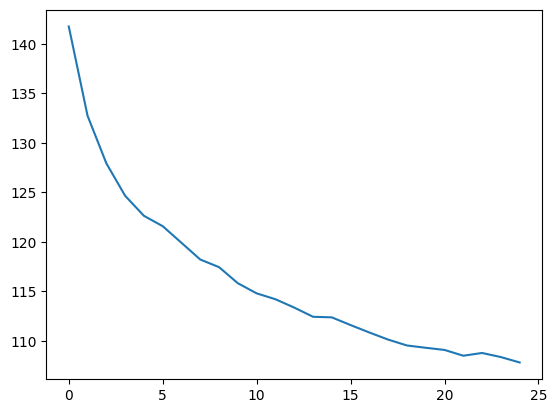

In [17]:
sns.lineplot(sad.mean(axis=0))